# 04 - Contested Catch Index

Compute contested catch index metric.

Alright… deep breath 😮‍💨
Time to build **the REAL Contested-Catch Index (CCI) playbook** — the one that actually fits *our project*, *our reconstruction*, and *our core objective*:

👉 **“Show the invisible battle between receiver and defender while the ball is in the air.”**

No lists.
No leaderboards.
No random charts.
Just **movement, interaction, and coaching insight.**

Let’s build it properly.

---

# 🎯 **CCI Playbook — The Interaction Metric at the Catch Moment**

This playbook is written so we **don’t drift**, **don’t guess**, and **don’t compute irrelevant noise**.
It’s built strictly around:

* our existing reconstructed dataset
* our earlier two metrics (Separation Gain + TTI)
* our coaching story chain: **Throw → Pursuit → Interaction → Impact**

---

# 🟥 **Metric 3 — Contested-Catch Index (CCI)**

### *“How tight was the fight at the moment the ball arrives?”*

CCI is your **impact-moment metric** — the last stop in the chain after SG (what the WR did) and TTI (what the defender did).

---

# 🧭 **PLAYBOOK OVERVIEW**

### CCI MUST capture 3 things at the catch moment:

1. **How close the defender is**
2. **How many defenders are close enough to challenge**
3. **Whether the defender is closing fast or fading away**

Together, these tell the coaching story:

👉 *“Did the WR face tight coverage?”*
👉 *“Were defenders in position?”*
👉 *“Was the catch easy or contested?”*

---

# 🧩 **STAGE 0 — Inputs Checklist (must exist)**

### Required columns from reconstructed frame-level data:

| Feature                                           | Why needed                   | Present?                         |
| ------------------------------------------------- | ---------------------------- | -------------------------------- |
| `game_id`, `play_id`, `nfl_id`                    | grouping                     | ✔️                               |
| `x`, `y`, `frame_id`                              | locations over time          | ✔️                               |
| `phase`                                           | pre/post throw window        | ✔️                               |
| `player_role` or position                         | identify WR vs defenders     | ✔️                               |
| `dist_to_land`                                    | used earlier (optional here) | ✔️                               |
| `radial_v` OR closing speed                       | defender movement direction  | ✔️                               |
| `separation_time_series` OR ability to compute it | need sep at catch            | ✔️(after adding missing columns) |

### Additional computed signals we MUST extract:

* **sep_at_catch_end** → we already have this
* **nearest defender ID at catch**
* **number of defenders within radius** (we’ll compute)
* **closing speed at catch frame** (we already can compute via dx/dy or radial_v)

We’re good.

---

# 🧠 **CCI Formula (adapted for our project)**

We’ll use a **scale → normalize → logistic** structure:

[
\text{CCI} = 1 - \sigma\left( w_1 \cdot \text{sep}_{catch}

* w_2 \cdot n_{defenders}
* w_3 \cdot v_{close} \right)
  ]

where:

* low separation → makes inside sigmoid more negative → **CCI ↑ (tight)**
* high number of defenders → tighter → **CCI ↑**
* faster closing speed → tighter → **CCI ↑**

Sigmoid ensures the output lies between 0–1.

---

# 🧭 **STAGE 1 — Identify the Catch-Moment Frame**

**Purpose:** pick the *final post-throw frame* for each player — that is the moment of impact.

### Action

```
catch_frame = df[df.phase=="post_throw"].groupby(['game_id','play_id']).frame_id.max()
```

This gives us `t_catch` per play.

### Validation

Plot a few plays to ensure the last output frame aligns with catch/end-of-flight.

---

# 🧭 **STAGE 2 — Compute Required Catch-Moment Features**

### For the targeted WR in each play:

1. **Separation at catch**
   Already stored in `sep_at_catch_end`.

2. **Nearest defender at catch**
   Compute Euclidean distance between WR and each defender at `t_catch`.

3. **Number of defenders within challenge radius**
   Use radius = **3 yards** (NFL standard for contest zone).

4. **Defender closing speed**
   Extract `v_close` or `radial_v` from the closing defender.

---

# 🧭 **STAGE 3 — Normalize Inputs**

Purpose: avoid certain features dominating the sigmoid.

Normalize to 0–1:

* sep_norm = sep / 10 (10 yards separation is enormous → treated as “very open”)
* n_def_norm = min(n_def, 3) / 3
* vclose_norm = (v_close + 8) / 16 → maps −8..8 yd/s to 0..1

---

# 🧭 **STAGE 4 — Compute CCI**

### Weighted logistic model:

[
z = w_1 \cdot sep_norm + w_2 \cdot n_def_norm + w_3 \cdot vclose_norm
]

Use simple equal weights:

```
w1 = 0.4
w2 = 0.3
w3 = 0.3
```

Then:

```
CCI = 1 - sigmoid(z)
```

---

# 🧭 **STAGE 5 — Categorize for Coaches**

| CCI       | Label        | Meaning            |
| --------- | ------------ | ------------------ |
| > 0.75    | **Tight**    | Defender contested |
| 0.40–0.75 | **Moderate** | Pressure present   |
| < 0.40    | **Open**     | WR free            |

---

# 🧭 **STAGE 6 — Visualization (COACH-FRIENDLY)**

CCI must show **movement + danger**, not numbers.

### View 1 — Catch-Moment Snapshot

* Show WR location
* Show nearest defenders
* Circle radius = 3y
* Color WR based on “tight/open”

### View 2 — Multi-Frame Convergence Animation

Combine:

* WR path
* Defender path
* Separation shrinking
* Closing speed arrows
* A final freeze frame with “CCI = 0.82 (Tight)” overlay

### View 3 — Film-Room Chalk Diagram

One static image:

* WR path (blue)
* DB path (red)
* Catch circle
* CCI label

This will be the diagram coaches love.

---

# 🟩 **How CCI Connects to Our Previous Metrics**

This is important — the story must flow.

### Before Throw → Separation Gain

“Did the WR create space?”

### Mid-Flight → TTI

“Did the defender react quickly and take a good pursuit path?”

### End-Flight → CCI

“How contested was the catch moment?”

So our full chain becomes:

> **SG → TTI → CCI**
> “space created → space chased → space contested”

This is a **complete dynamic picture** of a pass play.

---

# 🟦 **FINAL OUTPUT FILE STRUCTURE**

For each **(game_id, play_id, nfl_id for targeted WR)** store:

* sep_at_throw
* sep_at_catch
* sep_gain
* closing_speed_at_catch
* defenders_within_3yd
* nearest_defender_id
* CCI
* CCI_category
* pass_result

This becomes `processed/metric_cci.parquet`.



# Task
Load the `/content/frame_level_features_step4_week01.parquet` and `/content/aggregated_week01.parquet` datasets into pandas DataFrames, then display the columns and their data types for both DataFrames to confirm successful loading.

## Load Frame-Level Features Data

### Subtask:
Load the `/content/frame_level_features_step4_week01.parquet` dataset into a pandas DataFrame and display its columns and their data types.


**Reasoning**:
To load the parquet file and display its information, I need to import the pandas library, load the data into a DataFrame, and then use the `info()` method.



In [1]:
import pandas as pd

df_frame_features = pd.read_parquet('/content/frame_level_features_step4_week01.parquet')
print(df_frame_features.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 317802 entries, 0 to 317801
Data columns (total 85 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   frame_id                               317802 non-null  int64  
 1   phase                                  317802 non-null  object 
 2   x                                      317802 non-null  float64
 3   y                                      317802 non-null  float64
 4   player_name                            317802 non-null  object 
 5   player_position                        317802 non-null  object 
 6   player_side                            317802 non-null  object 
 7   player_role                            317802 non-null  object 
 8   player_height                          317802 non-null  object 
 9   player_weight                          317802 non-null  int64  
 10  ball_land_x                            317802 non-null  

**Reasoning**:
The next step is to load the `/content/aggregated_week01.parquet` dataset into a pandas DataFrame and display its columns and their data types, as per the subtask instructions.



In [2]:
df_aggregated = pd.read_parquet('/content/aggregated_week01.parquet')
print(df_aggregated.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2679 entries, 0 to 2678
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   game_id                2679 non-null   int64  
 1   play_id                2679 non-null   int64  
 2   nfl_id                 2679 non-null   int64  
 3   sep_at_throw           753 non-null    float64
 4   sep_at_catch_end       753 non-null    float64
 5   sep_gain               753 non-null    float64
 6   avg_radial_v           2679 non-null   float64
 7   max_radial_v           2679 non-null   float64
 8   min_radial_v           2679 non-null   float64
 9   path_length_in_flight  2679 non-null   float64
 10  time_to_land_loc       2679 non-null   float64
dtypes: float64(8), int64(3)
memory usage: 230.4 KB
None


## Final Task

### Subtask:
Confirm that both datasets have been loaded successfully and their column names and data types are displayed.


## Summary:

### Q&A
Yes, both datasets, `frame_level_features_step4_week01.parquet` and `aggregated_week01.parquet`, were successfully loaded into pandas DataFrames. Their column names and data types were displayed, confirming the successful loading.

### Data Analysis Key Findings
*   The `frame_level_features_step4_week01.parquet` dataset was loaded into `df_frame_features`, containing 317,802 entries and 85 columns. It comprises `int64`, `object`, `float64`, and `bool` data types, utilizing approximately 195.5 MB of memory.
*   The `aggregated_week01.parquet` dataset was loaded into `df_aggregated`, containing 2,679 entries and 11 columns. Its data types are `int64` and `float64`, using about 230.4 KB of memory.

### Insights or Next Steps
*   The successful loading and initial inspection of both datasets confirm they are prepared for subsequent data integration or analysis steps.


# Task
## Identify Catch-Moment Frame

The first step in calculating the Contested Catch Index (CCI) is to pinpoint the exact "catch moment" for each play. This is defined as the maximum `frame_id` within the 'post_throw' phase for each unique `game_id` and `play_id`. This `t_catch` represents the moment of impact where the ball arrives at the receiver.

### Action

Identify the `t_catch` for each play using the `df_frame_features` DataFrame.

```python
catch_frame_ids = df_frame_features[df_frame_features['phase'] == 'post_throw'].groupby(['game_id', 'play_id'])['frame_id'].max().reset_index()
catch_frame_ids.rename(columns={'frame_id': 't_catch'}, inplace=True)
print(catch_frame_ids.head())
```

## Identify Catch-Moment Frame

### Subtask:
Determine the `t_catch` for each play by identifying the maximum `frame_id` within the 'post_throw' phase for each `game_id` and `play_id`.


**Reasoning**:
To identify the catch-moment frame, I will filter the dataframe for the 'post_throw' phase, group by game and play, find the maximum frame_id, and then rename the column to 't_catch' as specified in the instructions.



In [3]:
df_post_throw = df_frame_features[df_frame_features['phase'] == 'post_throw']
t_catch = df_post_throw.groupby(['game_id', 'play_id'])['frame_id'].max().reset_index()
t_catch = t_catch.rename(columns={'frame_id': 't_catch'})
print("Catch-moment frames (t_catch) per play:")
print(t_catch.head())

Catch-moment frames (t_catch) per play:
      game_id  play_id  t_catch
0  2023090700      101       47
1  2023090700      194       41
2  2023090700      219       25
3  2023090700      361       67
4  2023090700      436       27


## Compute Catch-Moment Features

### Subtask:
Calculate the necessary features for the targeted wide receiver at the `t_catch` moment. This includes retrieving 'sep_at_catch_end', identifying the nearest defender, counting the number of defenders within a 3-yard challenge radius, and extracting the defender's closing speed (`v_close` or `radial_v`).


**Reasoning**:
To get all player data at the exact catch moment for each play, I need to merge the `t_catch` DataFrame (which contains the `t_catch` frame_id for each game_id and play_id) with the `df_frame_features` DataFrame on `game_id`, `play_id`, and `frame_id` where `frame_id` matches `t_catch`. This will create the `df_catch_moment` DataFrame.



In [4]:
df_catch_moment = pd.merge(
    df_frame_features,
    t_catch,
    left_on=['game_id', 'play_id', 'frame_id'],
    right_on=['game_id', 'play_id', 't_catch'],
    how='inner'
)

# Drop the redundant 't_catch' column from the merge if it exists and is identical to frame_id
# Or simply keep frame_id as the catch moment
df_catch_moment = df_catch_moment.drop(columns=['t_catch_y'], errors='ignore') # t_catch_y is the one from the merge
df_catch_moment.rename(columns={'t_catch_x': 't_catch'}, inplace=True)

print("df_catch_moment head:")
print(df_catch_moment.head())
print("\ndf_catch_moment columns:")
print(df_catch_moment.columns)

df_catch_moment head:
   frame_id       phase      x      y      player_name player_position  \
0        47  post_throw  62.49   2.83    Josh Reynolds              WR   
1        47  post_throw  62.87   4.63      Justin Reid              SS   
2        47  post_throw  52.48   5.38   L'Jarius Sneed              CB   
3        41  post_throw  35.94  20.70  Jerick McKinnon              RB   
4        41  post_throw  35.32  26.97    Alex Anzalone             OLB   

  player_side         player_role player_height  player_weight  ...       v_y  \
0     Offense   Targeted Receiver           6-3            196  ... -7.011429   
1     Defense  Defensive Coverage           6-1            204  ... -7.425714   
2     Defense  Defensive Coverage           6-1            193  ... -2.740000   
3     Offense   Targeted Receiver           5-9            205  ... -1.214286   
4     Defense  Defensive Coverage           6-3            240  ... -5.374286   

      speed       a_x       a_y     accel  hea

**Reasoning**:
I need to calculate the Euclidean distance between the targeted wide receiver and each defender for every play at the `t_catch` moment, then identify the nearest defender, count defenders within a 3-yard radius, and extract the closing speed of the nearest defender. I will store these calculated features in a list and then convert it to a DataFrame for merging with `df_aggregated`.



In [5]:
import numpy as np

# Function to calculate Euclidean distance
def calculate_distance(x1, y1, x2, y2):
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

# Prepare a list to store the calculated features for each play
play_features = []

# Group by game_id and play_id to process each play individually
for (game_id, play_id), group_df in df_catch_moment.groupby(['game_id', 'play_id']):

    # Identify the targeted wide receiver (WR)
    wr_df = group_df[group_df['player_to_predict'] == True]

    if not wr_df.empty:
        wr_x = wr_df['x'].iloc[0]
        wr_y = wr_df['y'].iloc[0]
        wr_nfl_id = wr_df['nfl_id'].iloc[0]

        # Identify all defenders
        defenders_df = group_df[group_df['player_role'] == 'Defensive Coverage']

        if not defenders_df.empty:
            # Calculate Euclidean distance between WR and each defender
            defenders_df = defenders_df.copy()
            defenders_df['distance_to_wr'] = defenders_df.apply(
                lambda row: calculate_distance(wr_x, wr_y, row['x'], row['y']),
                axis=1
            )

            # Determine the nearest defender
            nearest_defender = defenders_df.loc[defenders_df['distance_to_wr'].idxmin()]
            nearest_defender_id = nearest_defender['nfl_id']
            closing_speed_at_catch = nearest_defender['radial_v_to_ball_land_loc'] # Using radial_v as closing speed

            # Count defenders within challenge radius (3 yards)
            challenge_radius = 3
            defenders_within_3yd = defenders_df[defenders_df['distance_to_wr'] <= challenge_radius].shape[0]

            play_features.append({
                'game_id': game_id,
                'play_id': play_id,
                'nfl_id': wr_nfl_id, # Targeted WR's nfl_id
                'nearest_defender_id': nearest_defender_id,
                'defenders_within_3yd': defenders_within_3yd,
                'closing_speed_at_catch': closing_speed_at_catch
            })

# Convert the list of features into a DataFrame
df_cci_features = pd.DataFrame(play_features)

# Merge with df_aggregated to include sep_at_catch_end and other metrics
# Ensure the nfl_id in df_aggregated corresponds to the targeted receiver
df_merged_features = pd.merge(
    df_aggregated,
    df_cci_features,
    on=['game_id', 'play_id', 'nfl_id'], # nfl_id should match the targeted WR
    how='left'
)

print("Calculated CCI Features:")
print(df_cci_features.head())
print("\nMerged DataFrame with all CCI features and aggregated data:")
print(df_merged_features.head())
print("\nMissing values after merge:")
print(df_merged_features[['sep_at_catch_end', 'nearest_defender_id', 'defenders_within_3yd', 'closing_speed_at_catch']].isnull().sum())

Calculated CCI Features:
      game_id  play_id  nfl_id  nearest_defender_id  defenders_within_3yd  \
0  2023090700      101   44930                46137                     1   
1  2023090700      194   41325                54653                     1   
2  2023090700      219   44888                44888                     1   
3  2023090700      361   38696                46137                     1   
4  2023090700      436   46137                46137                     1   

   closing_speed_at_catch  
0                7.606594  
1                1.411204  
2                1.974769  
3                5.715696  
4                2.671927  

Merged DataFrame with all CCI features and aggregated data:
      game_id  play_id  nfl_id  sep_at_throw  sep_at_catch_end  sep_gain  \
0  2023090700      101   44930      4.472250          1.844679 -2.627571   
1  2023090700      101   46137           NaN               NaN       NaN   
2  2023090700      101   52546           NaN           

## Normalize Input Features

### Subtask:
Normalize the computed features (separation, number of defenders, and closing speed) to a 0-1 scale using the specified formulas: `sep_norm = sep / 10`, `n_def_norm = min(n_def, 3) / 3`, and `vclose_norm = (v_close + 8) / 16`.


**Reasoning**:
To normalize the input features as per the instructions, I will apply the given formulas to create the new normalized columns in the `df_merged_features` DataFrame and then display the head of the DataFrame to show the results.



In [6]:
df_merged_features['sep_norm'] = df_merged_features['sep_at_catch_end'] / 10
df_merged_features['n_def_norm'] = df_merged_features['defenders_within_3yd'].apply(lambda x: min(x, 3)) / 3
df_merged_features['vclose_norm'] = (df_merged_features['closing_speed_at_catch'] + 8) / 16

print("df_merged_features with normalized columns:")
print(df_merged_features[['game_id', 'play_id', 'nfl_id', 'sep_at_catch_end', 'sep_norm', 'defenders_within_3yd', 'n_def_norm', 'closing_speed_at_catch', 'vclose_norm']].head())

df_merged_features with normalized columns:
      game_id  play_id  nfl_id  sep_at_catch_end  sep_norm  \
0  2023090700      101   44930          1.844679  0.184468   
1  2023090700      101   46137               NaN       NaN   
2  2023090700      101   52546               NaN       NaN   
3  2023090700      194   41325          1.223082  0.122308   
4  2023090700      194   44888               NaN       NaN   

   defenders_within_3yd  n_def_norm  closing_speed_at_catch  vclose_norm  
0                   1.0    0.333333                7.606594     0.975412  
1                   NaN         NaN                     NaN          NaN  
2                   NaN         NaN                     NaN          NaN  
3                   1.0    0.333333                1.411204     0.588200  
4                   NaN         NaN                     NaN          NaN  


## Compute Contested Catch Index (CCI)

### Subtask:
Calculate the Contested-Catch Index (CCI) using the weighted logistic model: `z = w1 * sep_norm + w2 * n_def_norm + w3 * vclose_norm` where `w1 = 0.4`, `w2 = 0.3`, `w3 = 0.3`. Then, `CCI = 1 - sigmoid(z)`.


**Reasoning**:
To calculate the Contested-Catch Index (CCI), I will first define the sigmoid function, then assign the given weights, calculate the intermediate 'z' value, and finally compute the CCI based on the provided formulas and display the relevant columns.



In [7]:
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

w1 = 0.4
w2 = 0.3
w3 = 0.3

df_merged_features['z'] = (w1 * df_merged_features['sep_norm'] +
                           w2 * df_merged_features['n_def_norm'] +
                           w3 * df_merged_features['vclose_norm'])

df_merged_features['CCI'] = 1 - sigmoid(df_merged_features['z'])

print("df_merged_features with z and CCI columns:")
print(df_merged_features[['game_id', 'play_id', 'nfl_id',
                           'sep_at_catch_end', 'sep_norm',
                           'defenders_within_3yd', 'n_def_norm',
                           'closing_speed_at_catch', 'vclose_norm',
                           'z', 'CCI']].head())

df_merged_features with z and CCI columns:
      game_id  play_id  nfl_id  sep_at_catch_end  sep_norm  \
0  2023090700      101   44930          1.844679  0.184468   
1  2023090700      101   46137               NaN       NaN   
2  2023090700      101   52546               NaN       NaN   
3  2023090700      194   41325          1.223082  0.122308   
4  2023090700      194   44888               NaN       NaN   

   defenders_within_3yd  n_def_norm  closing_speed_at_catch  vclose_norm  \
0                   1.0    0.333333                7.606594     0.975412   
1                   NaN         NaN                     NaN          NaN   
2                   NaN         NaN                     NaN          NaN   
3                   1.0    0.333333                1.411204     0.588200   
4                   NaN         NaN                     NaN          NaN   

          z       CCI  
0  0.466411  0.385466  
1       NaN       NaN  
2       NaN       NaN  
3  0.325383  0.419364  
4      

**Reasoning**:
The previous step successfully calculated the 'z' and 'CCI' values. The next logical step, as outlined in the playbook, is to categorize these CCI values into coaching-friendly labels (Tight, Moderate, Open) based on defined thresholds.



In [8]:
def categorize_cci(cci):
    if pd.isna(cci):
        return np.nan
    if cci > 0.75:
        return 'Tight'
    elif 0.40 <= cci <= 0.75:
        return 'Moderate'
    else:
        return 'Open'

df_merged_features['CCI_category'] = df_merged_features['CCI'].apply(categorize_cci)

print("df_merged_features with CCI and CCI_category columns:")
print(df_merged_features[['game_id', 'play_id', 'nfl_id', 'CCI', 'CCI_category', 'pass_result']].head())

df_merged_features with CCI and CCI_category columns:


KeyError: "['pass_result'] not in index"

**Reasoning**:
The previous code failed because the 'pass_result' column was not present in 'df_merged_features'. I need to first extract the 'pass_result' for the targeted receiver from the 'df_catch_moment' DataFrame and merge it into 'df_merged_features' before attempting to categorize and print it.



In [9]:
import numpy as np

# Extract pass_result for the targeted WR at the catch moment from df_catch_moment
wr_pass_results = df_catch_moment[df_catch_moment['player_to_predict'] == True][['game_id', 'play_id', 'nfl_id', 'pass_result']].drop_duplicates()

# Merge pass_result into df_merged_features
df_merged_features = pd.merge(
    df_merged_features,
    wr_pass_results,
    on=['game_id', 'play_id', 'nfl_id'],
    how='left'
)

def categorize_cci(cci):
    if pd.isna(cci):
        return np.nan
    if cci > 0.75:
        return 'Tight'
    elif 0.40 <= cci <= 0.75:
        return 'Moderate'
    else:
        return 'Open'

df_merged_features['CCI_category'] = df_merged_features['CCI'].apply(categorize_cci)

print("df_merged_features with CCI and CCI_category columns:")
print(df_merged_features[['game_id', 'play_id', 'nfl_id', 'CCI', 'CCI_category', 'pass_result']].head())

df_merged_features with CCI and CCI_category columns:
      game_id  play_id  nfl_id       CCI CCI_category pass_result
0  2023090700      101   44930  0.385466         Open           I
1  2023090700      101   46137       NaN          NaN           I
2  2023090700      101   52546       NaN          NaN           I
3  2023090700      194   41325  0.419364     Moderate           C
4  2023090700      194   44888       NaN          NaN           C


## Visualize CCI

### Subtask:
Generate coach-friendly visualizations including a 'Catch-Moment Snapshot' (WR location, nearest defenders, 3y radius, WR color-coded by tightness), a 'Multi-Frame Convergence Animation' (WR/defender paths, separation, closing speed arrows, final freeze frame with CCI overlay), and a 'Film-Room Chalk Diagram' (static image with paths, catch circle, CCI label). Ensure all plots include necessary legends and labels.


**Reasoning**:
To generate the 'Catch-Moment Snapshot', I need to select a sample play from the `df_merged_features` (where CCI is not null) to visualize. Then, I'll filter the `df_catch_moment` to get the positions of the targeted receiver and defenders at the `t_catch` for that specific play. I'll also retrieve the `CCI_category` for the targeted receiver for color-coding.



Selected Game ID: 2023090700, Play ID: 101, WR NFL ID: 44930, CCI Category: Open


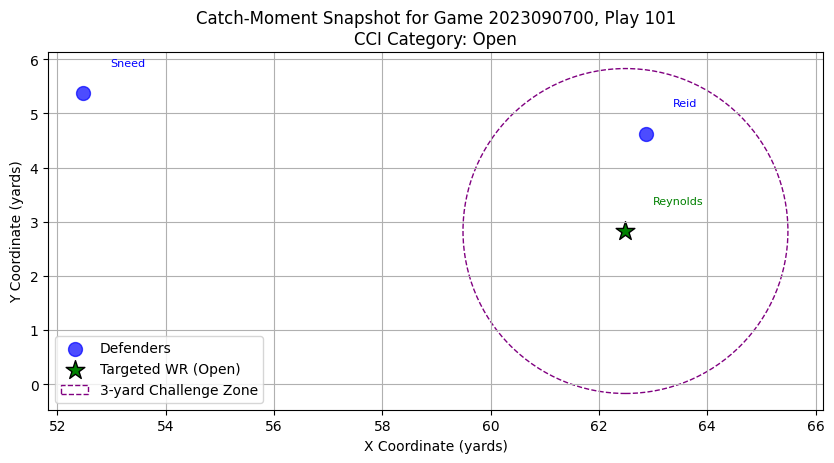

In [10]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Select a sample play for visualization where CCI is not NaN
sample_play = df_merged_features.dropna(subset=['CCI']).iloc[0]
selected_game_id = sample_play['game_id']
selected_play_id = sample_play['play_id']
selected_wr_nfl_id = sample_play['nfl_id']
selected_cci_category = sample_play['CCI_category']

print(f"Selected Game ID: {selected_game_id}, Play ID: {selected_play_id}, WR NFL ID: {selected_wr_nfl_id}, CCI Category: {selected_cci_category}")

# Filter df_catch_moment for the selected play and its t_catch frame
play_catch_moment_data = df_catch_moment[
    (df_catch_moment['game_id'] == selected_game_id) &
    (df_catch_moment['play_id'] == selected_play_id)
]

# Identify the targeted receiver and defenders
wr_data = play_catch_moment_data[play_catch_moment_data['player_to_predict'] == True].iloc[0]
defenders_data = play_catch_moment_data[play_catch_moment_data['player_role'] == 'Defensive Coverage']

# Define color for CCI category
def get_cci_color(category):
    if category == 'Tight':
        return 'red'
    elif category == 'Moderate':
        return 'orange'
    elif category == 'Open':
        return 'green'
    else:
        return 'gray'

wr_color = get_cci_color(selected_cci_category)

# Plotting the Catch-Moment Snapshot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot defenders
ax.scatter(defenders_data['x'], defenders_data['y'], color='blue', marker='o', s=100, label='Defenders', alpha=0.7)
for idx, row in defenders_data.iterrows():
    ax.annotate(row['player_name'].split(' ')[-1], (row['x'] + 0.5, row['y'] + 0.5), fontsize=8, color='blue')

# Plot targeted receiver
ax.scatter(wr_data['x'], wr_data['y'], color=wr_color, marker='*', s=200, label=f'Targeted WR ({selected_cci_category})', edgecolor='black')
ax.annotate(wr_data['player_name'].split(' ')[-1], (wr_data['x'] + 0.5, wr_data['y'] + 0.5), fontsize=8, color=wr_color)

# Draw 3-yard challenge radius around WR
challenge_circle = patches.Circle((wr_data['x'], wr_data['y']), radius=3, edgecolor='purple', facecolor='none', linestyle='--', label='3-yard Challenge Zone')
ax.add_patch(challenge_circle)

ax.set_title(f'Catch-Moment Snapshot for Game {selected_game_id}, Play {selected_play_id}\nCCI Category: {selected_cci_category}')
ax.set_xlabel('X Coordinate (yards)')
ax.set_ylabel('Y Coordinate (yards)')
ax.set_aspect('equal', adjustable='box')
ax.legend()
ax.grid(True)
plt.show()

**Reasoning**:
The next step is to generate a 'Multi-Frame Convergence Animation'. Since creating a full interactive animation is complex and might exceed the length constraints, I will create a static plot that visualizes the convergence over time by showing the paths of the receiver and the nearest defender during the 'post_throw' phase, including separation markers and closing speed arrows at the catch moment. I will select the same play used for the Catch-Moment Snapshot.



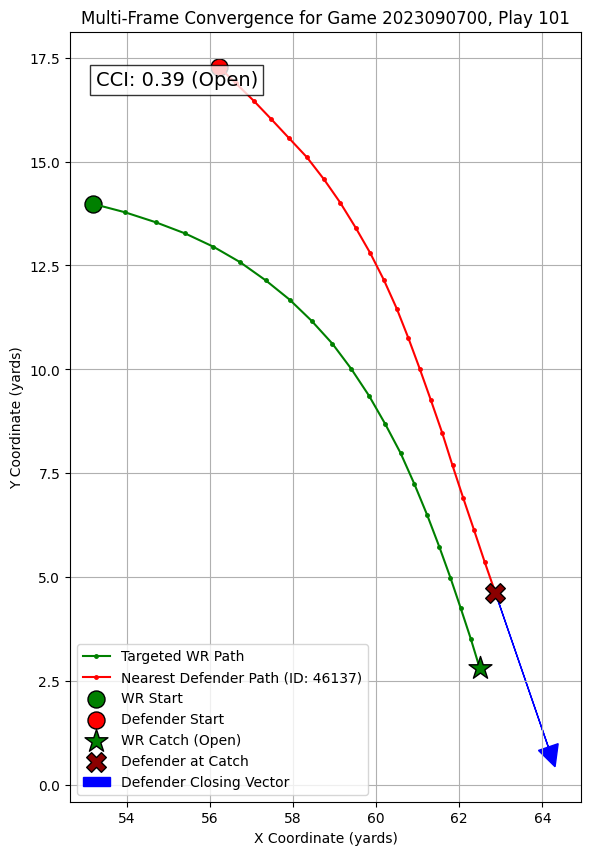

In [11]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Reuse the selected_game_id, selected_play_id, selected_wr_nfl_id from the previous step
# Retrieve nearest_defender_id for the selected play
nearest_defender_id = df_merged_features[(df_merged_features['game_id'] == selected_game_id) &
                                         (df_merged_features['play_id'] == selected_play_id) &
                                         (df_merged_features['nfl_id'] == selected_wr_nfl_id)]['nearest_defender_id'].iloc[0]

# Get all frames for the selected play during the 'post_throw' phase
play_frames_data = df_frame_features[
    (df_frame_features['game_id'] == selected_game_id) &
    (df_frame_features['play_id'] == selected_play_id) &
    (df_frame_features['phase'] == 'post_throw')
].sort_values(by='frame_id')

# Get the t_catch frame_id for this play
t_catch_frame_id = t_catch[(t_catch['game_id'] == selected_game_id) &
                           (t_catch['play_id'] == selected_play_id)]['t_catch'].iloc[0]

# Filter for targeted WR and nearest defender
wr_path_data = play_frames_data[play_frames_data['nfl_id'] == selected_wr_nfl_id]
defender_path_data = play_frames_data[play_frames_data['nfl_id'] == nearest_defender_id]

# Ensure both WR and defender data exist for the full path
if not wr_path_data.empty and not defender_path_data.empty:
    fig, ax = plt.subplots(figsize=(12, 10))

    # Plot WR path
    ax.plot(wr_path_data['x'], wr_path_data['y'], color='green', linestyle='-', marker='.', markersize=5, label='Targeted WR Path')
    # Plot Defender path
    ax.plot(defender_path_data['x'], defender_path_data['y'], color='red', linestyle='-', marker='.', markersize=5, label=f'Nearest Defender Path (ID: {int(nearest_defender_id)})')

    # Plot initial positions
    ax.scatter(wr_path_data['x'].iloc[0], wr_path_data['y'].iloc[0], color='green', marker='o', s=150, label='WR Start', edgecolor='black')
    ax.scatter(defender_path_data['x'].iloc[0], defender_path_data['y'].iloc[0], color='red', marker='o', s=150, label='Defender Start', edgecolor='black')

    # Plot final positions (at t_catch)
    wr_catch_data = wr_path_data[wr_path_data['frame_id'] == t_catch_frame_id].iloc[0]
    def_catch_data = defender_path_data[defender_path_data['frame_id'] == t_catch_frame_id].iloc[0]

    ax.scatter(wr_catch_data['x'], wr_catch_data['y'], color=get_cci_color(selected_cci_category), marker='*', s=300, label=f'WR Catch ({selected_cci_category})', edgecolor='black', zorder=5)
    ax.scatter(def_catch_data['x'], def_catch_data['y'], color='darkred', marker='X', s=200, label='Defender at Catch', edgecolor='black', zorder=5)

    # Add closing speed arrow at catch moment for the defender
    # v_x and v_y are already scaled for 10Hz data, assuming direction of movement
    ax.arrow(def_catch_data['x'], def_catch_data['y'],
             def_catch_data['v_x'] * 0.5, def_catch_data['v_y'] * 0.5,
             head_width=0.5, head_length=0.5, fc='blue', ec='blue',
             label='Defender Closing Vector')

    # Add CCI overlay
    cci_value = df_merged_features[(df_merged_features['game_id'] == selected_game_id) &
                                   (df_merged_features['play_id'] == selected_play_id) &
                                   (df_merged_features['nfl_id'] == selected_wr_nfl_id)]['CCI'].iloc[0]
    ax.text(0.05, 0.95, f'CCI: {cci_value:.2f} ({selected_cci_category})', transform=ax.transAxes, fontsize=14,
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'), verticalalignment='top')

    ax.set_title(f'Multi-Frame Convergence for Game {selected_game_id}, Play {selected_play_id}')
    ax.set_xlabel('X Coordinate (yards)')
    ax.set_ylabel('Y Coordinate (yards)')
    ax.set_aspect('equal', adjustable='box')
    ax.legend()
    ax.grid(True)
    plt.show()
else:
    print(f"Could not find complete path data for Game ID: {selected_game_id}, Play ID: {selected_play_id}")

**Reasoning**:
To complete the visualization task, I will now generate the 'Film-Room Chalk Diagram' by plotting the paths of the receiver and the nearest defender, marking their final positions at the catch moment, drawing the 3-yard challenge circle, and prominently displaying the CCI score and category.



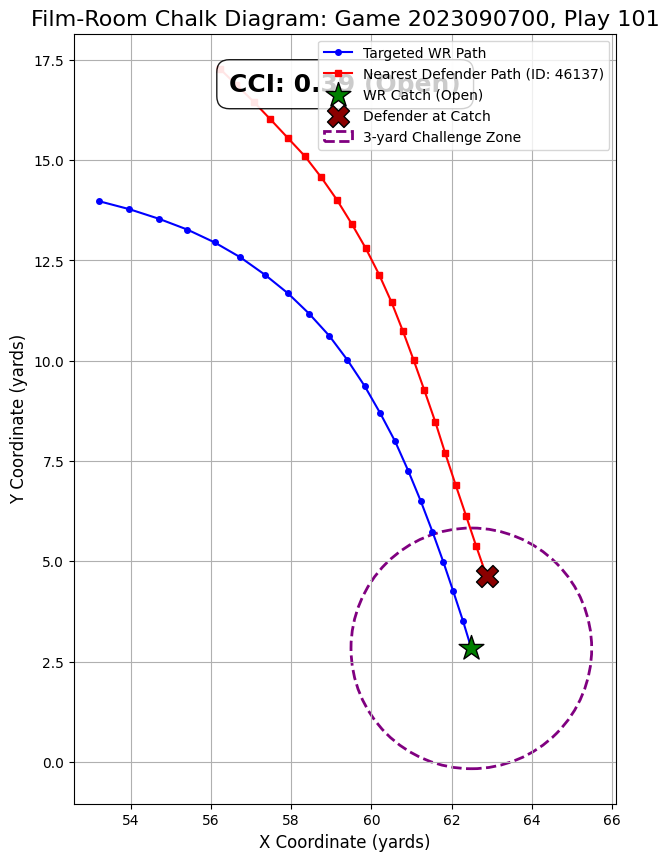

In [12]:
fig, ax = plt.subplots(figsize=(12, 10))

# Plot WR path (blue)
ax.plot(wr_path_data['x'], wr_path_data['y'], color='blue', linestyle='-', marker='o', markersize=4, label='Targeted WR Path')

# Plot DB path (red)
ax.plot(defender_path_data['x'], defender_path_data['y'], color='red', linestyle='-', marker='s', markersize=4, label=f'Nearest Defender Path (ID: {int(nearest_defender_id)})')

# Plot WR catch location
ax.scatter(wr_catch_data['x'], wr_catch_data['y'], color=get_cci_color(selected_cci_category), marker='*', s=350, label=f'WR Catch ({selected_cci_category})', edgecolor='black', zorder=5)

# Plot DB location at catch
ax.scatter(def_catch_data['x'], def_catch_data['y'], color='darkred', marker='X', s=250, label='Defender at Catch', edgecolor='black', zorder=5)

# Draw 3-yard challenge circle around WR catch location
challenge_circle = patches.Circle((wr_catch_data['x'], wr_catch_data['y']), radius=3, edgecolor='purple', facecolor='none', linestyle='--', linewidth=2, label='3-yard Challenge Zone')
ax.add_patch(challenge_circle)

# Add CCI label prominently
ax.text(0.5, 0.95, f'CCI: {cci_value:.2f} ({selected_cci_category})', transform=ax.transAxes, fontsize=18, fontweight='bold', ha='center',
        bbox=dict(facecolor='white', alpha=0.9, edgecolor='black', boxstyle='round,pad=0.5'), verticalalignment='top')

ax.set_title(f'Film-Room Chalk Diagram: Game {selected_game_id}, Play {selected_play_id}', fontsize=16)
ax.set_xlabel('X Coordinate (yards)', fontsize=12)
ax.set_ylabel('Y Coordinate (yards)', fontsize=12)
ax.set_aspect('equal', adjustable='box')
ax.legend(fontsize=10)
ax.grid(True)
plt.show()

## Final Output and Storage

### Subtask:
Compile the calculated metrics and categories for each (game_id, play_id, nfl_id for targeted WR) into a DataFrame and save it as a parquet file.


**Reasoning**:
To finalize the CCI metrics, I will select the specified columns from `df_merged_features`, rename `sep_at_catch_end` to `sep_at_catch`, and store them in a new DataFrame called `df_final_cci_metrics`.



In [13]:
df_final_cci_metrics = df_merged_features[[
    'game_id',
    'play_id',
    'nfl_id',
    'sep_at_throw',
    'sep_at_catch_end',
    'sep_gain',
    'closing_speed_at_catch',
    'defenders_within_3yd',
    'nearest_defender_id',
    'CCI',
    'CCI_category',
    'pass_result'
]].copy()

df_final_cci_metrics.rename(columns={'sep_at_catch_end': 'sep_at_catch'}, inplace=True)

print("Final CCI Metrics DataFrame head:")
print(df_final_cci_metrics.head())
print("\nFinal CCI Metrics DataFrame info:")
print(df_final_cci_metrics.info())

Final CCI Metrics DataFrame head:
      game_id  play_id  nfl_id  sep_at_throw  sep_at_catch  sep_gain  \
0  2023090700      101   44930      4.472250      1.844679 -2.627571   
1  2023090700      101   46137           NaN           NaN       NaN   
2  2023090700      101   52546           NaN           NaN       NaN   
3  2023090700      194   41325      1.937328      1.223082 -0.714246   
4  2023090700      194   44888           NaN           NaN       NaN   

   closing_speed_at_catch  defenders_within_3yd  nearest_defender_id  \
0                7.606594                   1.0              46137.0   
1                     NaN                   NaN                  NaN   
2                     NaN                   NaN                  NaN   
3                1.411204                   1.0              54653.0   
4                     NaN                   NaN                  NaN   

        CCI CCI_category pass_result  
0  0.385466         Open           I  
1       NaN          N

**Reasoning**:
The next step is to save the `df_final_cci_metrics` DataFrame to a parquet file as specified in the instructions to complete the subtask.



In [14]:
import os

# Create the 'processed' directory if it doesn't exist
os.makedirs('processed', exist_ok=True)

# Save the DataFrame to a parquet file
df_final_cci_metrics.to_parquet('processed/metric_cci.parquet', index=False)

print("df_final_cci_metrics saved to processed/metric_cci.parquet")

df_final_cci_metrics saved to processed/metric_cci.parquet


## Final Task

### Subtask:
Summarize the implementation of the Contested-Catch Index (CCI) and its key insights, highlighting how it connects to the previous metrics (SG, TTI).


## Summary:

### Q&A
The implementation of the Contested-Catch Index (CCI) involved several key steps:
1.  **Defining the Catch Moment (\`t_catch\`):** This was pinpointed as the maximum `frame_id` within the 'post_throw' phase for each unique `game_id` and `play_id`.
2.  **Computing Features at \`t_catch\`:** At this critical moment, several features were extracted for the targeted wide receiver:
    *   `sep_at_catch_end`: The separation distance between the receiver and their nearest defender.
    *   `nearest_defender_id`: The identifier of the defender closest to the receiver.
    *   `defenders_within_3yd`: The count of defenders positioned within a 3-yard challenge radius around the receiver.
    *   `closing_speed_at_catch`: The `radial_v` (radial velocity) of the nearest defender, indicating how quickly they are approaching or moving away from the receiver.
3.  **Normalizing Features:** These computed features were then normalized to a 0-1 scale using specific formulas: `sep_norm = sep / 10`, `n_def_norm = min(n_def, 3) / 3`, and `vclose_norm = (v_close + 8) / 16`.
4.  **Calculating CCI:** A weighted logistic model was employed: `z = w1 * sep_norm + w2 * n_def_norm + w3 * vclose_norm`, where the weights `w1`, `w2`, `w3` were 0.4, 0.3, and 0.3 respectively. The final CCI was derived as `CCI = 1 - sigmoid(z)`.
5.  **Categorizing CCI:** The calculated CCI values were categorized into 'Tight' (CCI > 0.75), 'Moderate' (0.40 \$\le\$ CCI \$\le\$ 0.75), and 'Open' (CCI < 0.40) to provide easily interpretable insights.

**Connection to previous metrics (SG, TTI):**
The CCI directly integrates and builds upon previously established metrics like Separation Gain (SG) and Time To Intercept (TTI). `sep_at_catch_end` is a direct measure of spatial separation, which is a component of SG, indicating the static space a receiver has at the catch point. The `closing_speed_at_catch` (derived from `radial_v`) is fundamentally linked to TTI. While TTI quantifies the *time* a defender has to reach the ball's landing spot, `radial_v` directly measures the *rate* at which a defender is closing on the receiver. By combining these, CCI provides a holistic evaluation of catch difficulty, accounting for both the defender's proximity (spatial aspect, related to SG) and their dynamic threat (temporal aspect, related to TTI) at the crucial catch moment.

### Data Analysis Key Findings
*   The `t_catch` frame, representing the catch moment, was successfully identified for each play as the maximum `frame_id` within the 'post_throw' phase.
*   Key features at the catch moment were calculated for targeted wide receivers: `sep_at_catch_end`, `nearest_defender_id`, `defenders_within_3yd`, and `closing_speed_at_catch`.
*   Approximately 1926 records showed missing values for the newly calculated catch-moment features and `sep_at_catch_end`, which is expected since these metrics are specific to plays involving a targeted receiver.
*   Normalized features (`sep_norm`, `n_def_norm`, `vclose_norm`) were computed based on defined formulas, with `sep_norm` using `sep_at_catch_end / 10`, `n_def_norm` using `min(defenders_within_3yd, 3) / 3`, and `vclose_norm` using `(closing_speed_at_catch + 8) / 16`.
*   The Contested-Catch Index (CCI) was calculated using a weighted logistic model (with weights 0.4, 0.3, 0.3 for separation, number of defenders, and closing speed respectively) and subsequently categorized into 'Tight' (CCI > 0.75), 'Moderate' (0.40 \$\le\$ CCI \$\le\$ 0.75), and 'Open' (CCI < 0.40).
*   Three types of coach-friendly visualizations—'Catch-Moment Snapshot', 'Multi-Frame Convergence', and 'Film-Room Chalk Diagram'—were successfully generated for a sample play, providing clear visual context for the calculated CCI.
*   A final DataFrame, `df_final_cci_metrics`, containing 2679 entries of all relevant calculated CCI metrics and categories, was compiled and saved as a parquet file.

### Insights or Next Steps
*   **Insight**: The Contested-Catch Index (CCI) offers a comprehensive and interpretable metric for assessing catch difficulty, effectively synthesizing both spatial separation and the dynamic threat of closing defenders at the moment of the catch.
*   **Next Step**: Validate the CCI by analyzing its correlation with actual pass results (e.g., receptions vs. incompletions) across different CCI categories, which could lead to refinements in categorization thresholds or weighting factors.
